# SwarmRegNet - Data Exploration

DREAM5 Network Inference Challenge Dataset Analysis


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pathlib import Path
import warnings
from typing import Union, Dict, List, Tuple
import networkx as nx
from scipy import stats, signal
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import adjusted_mutual_info_score
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [48]:
warnings.filterwarnings("ignore")

In [49]:
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["font.size"] = 12

## 1.0 Dataset Discovery and Loading


In [50]:
data_path = Path("../data/raw/dream5/training data/Network 1 - in silico")

In [51]:
def load_dream5_data(data_path: Path) -> Dict[str, pd.DataFrame]:
    """
    Load all DREAM5 Network 1 data files with proper error handling
    """

    file_configs = {
        "expression": {
            "filename": "net1_expression_data.tsv",
            "read_params": {"sep": "\t", "index_col": 0},
            "description": lambda df: f"{df.shape} (genes × samples)",
        },
        "chip_features": {
            "filename": "net1_chip_features.tsv",
            "read_params": {"sep": "\t"},
            "description": lambda df: f"{df.shape}",
        },
        "transcription_factors": {
            "filename": "net1_transcription_factors.tsv",
            "read_params": {"sep": "\t", "header": None, "names": ["TF"]},
            "description": lambda df: f"{len(df)} transcription factors",
        },
        "gene_ids": {
            "filename": "net1_gene_ids.tsv",
            "read_params": {"sep": "\t"},
            "description": lambda df: f"{df.shape}",
        },
        "metadata": {
            "filename": "SYNAPSE_METADATA_MANIFEST.tsv",
            "read_params": {"sep": "\t"},
            "description": lambda df: f"{df.shape}",
        },
    }

    loaded_data = {}
    for data_type, config in file_configs.items():
        file_path = data_path / config["filename"]

        if not file_path.exists():
            print(f"File not found: {config['filename']}")
            continue

        try:
            df = pd.read_csv(file_path, **config["read_params"])
            description = config["description"](df)

            print(f"Loaded {data_type}: {description}")
            loaded_data[data_type] = df

        except Exception as e:
            print(f"Error loading {data_type} from {config['filename']}: {e}")

    return loaded_data

In [52]:
dream5_data = load_dream5_data(data_path)

Loaded expression: (805, 1642) (genes × samples)
Loaded chip_features: (805, 8)
Loaded transcription_factors: 195 transcription factors
Loaded gene_ids: (1643, 2)
Loaded metadata: (4, 10)


## 2.0 Expression Data Deep Analysis


Shape: (805, 1642)
Genes: 805
Conditions/Timepoints: 1642
Data type: float64
Memory usage: 10.09 MB
Expression Statistics
Range: [0.0000, 2.1969]
Mean: 0.5429
Std: 0.1832
Missing values: 0
Time series analysis
Sample naming pattern: ['G2', 'G3', 'G4', 'G5', 'G6']...['G1641', 'G1642', 'G1643']
Potential temporal structure: Yes


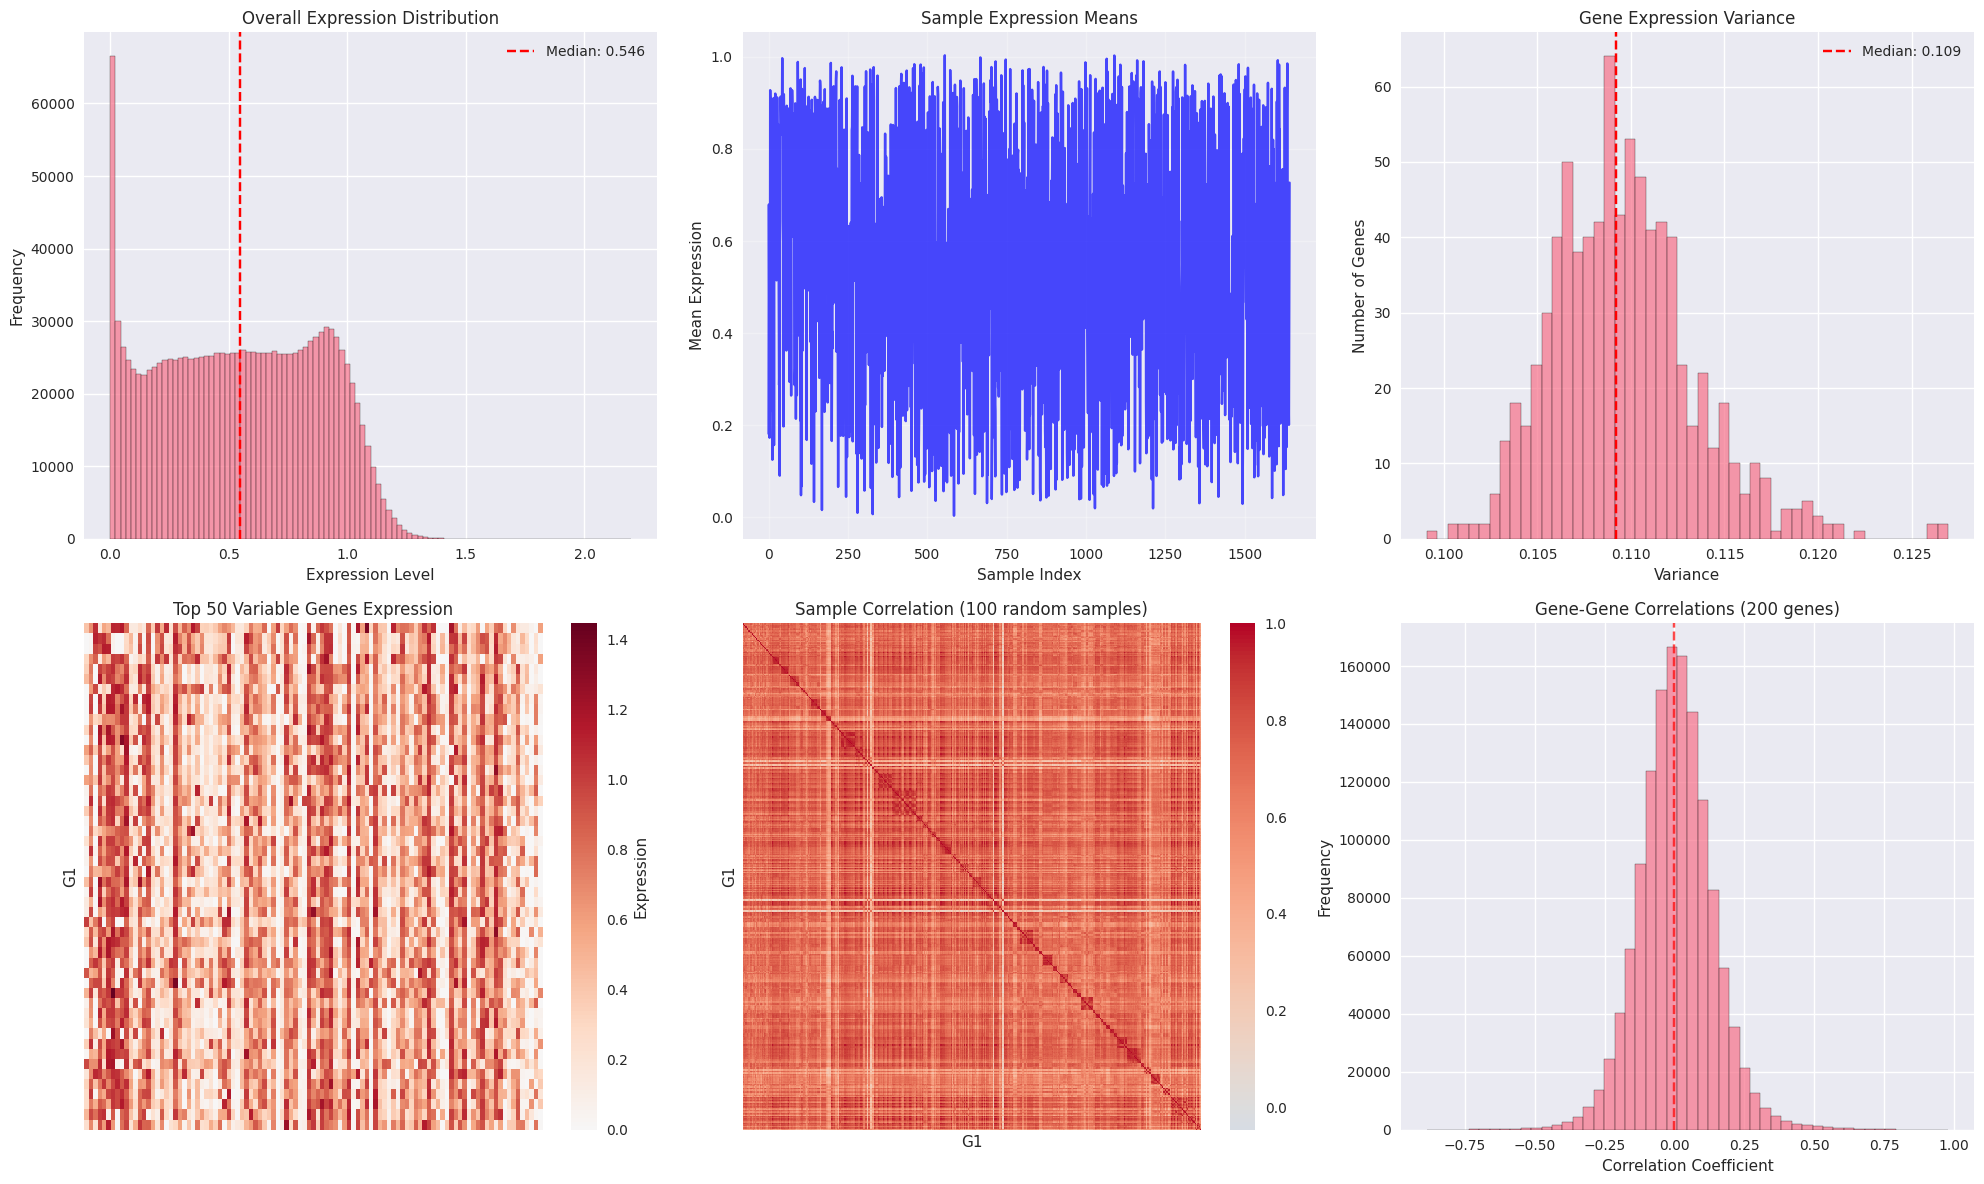

In [53]:
if "expression" in dream5_data:
    expr_data = dream5_data["expression"]

    print(f"Shape: {expr_data.shape}")
    print(f"Genes: {expr_data.shape[0]}")
    print(f"Conditions/Timepoints: {expr_data.shape[1]}")
    print(f"Data type: {expr_data.dtypes.iloc[0]}")
    print(f"Memory usage: {expr_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Statistics
    print("Expression Statistics")
    print(f"Range: [{expr_data.min().min():.4f}, {expr_data.max().max():.4f}]")
    print(f"Mean: {expr_data.mean().mean():.4f}")
    print(f"Std: {expr_data.std().mean():.4f}")
    print(f"Missing values: {expr_data.isnull().sum().sum()}")

    # Potential time series structure
    print("Time series analysis")

    sample_names = expr_data.columns.tolist()
    print(f"Sample naming pattern: {sample_names[:5]}...{sample_names[-3:]}")

    has_time_pattern = any(
        char.isdigit() for name in sample_names for char in str(name)
    )
    print(f"Potential temporal structure: {'Yes' if has_time_pattern else 'No'}")

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # 1. Overall expression distribution
    all_values = expr_data.values.flatten()
    axes[0, 0].hist(all_values, bins=100, alpha=0.7, edgecolor="black")
    axes[0, 0].set_title("Overall Expression Distribution")
    axes[0, 0].set_xlabel("Expression Level")
    axes[0, 0].set_ylabel("Frequency")
    axes[0, 0].axvline(
        np.median(all_values),
        color="red",
        linestyle="--",
        label=f"Median: {np.median(all_values):.3f}",
    )
    axes[0, 0].legend()

    # 2. Sample-wise expression means
    sample_means = expr_data.mean(axis=0)
    axes[0, 1].plot(sample_means.values, "b-", alpha=0.7)
    axes[0, 1].set_title("Sample Expression Means")
    axes[0, 1].set_xlabel("Sample Index")
    axes[0, 1].set_ylabel("Mean Expression")
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Gene expression variance
    gene_vars = expr_data.var(axis=1)
    axes[0, 2].hist(gene_vars, bins=50, alpha=0.7, edgecolor="black")
    axes[0, 2].set_title("Gene Expression Variance")
    axes[0, 2].set_xlabel("Variance")
    axes[0, 2].set_ylabel("Number of Genes")
    axes[0, 2].axvline(
        gene_vars.median(),
        color="red",
        linestyle="--",
        label=f"Median: {gene_vars.median():.3f}",
    )
    axes[0, 2].legend()

    # 4. Expression heatmap (top variable genes)
    top_var_genes = gene_vars.nlargest(50).index
    heatmap_data = expr_data.loc[top_var_genes]

    if heatmap_data.shape[1] > 100:
        step = heatmap_data.shape[1] // 100
        heatmap_data = heatmap_data.iloc[:, ::step]

    sns.heatmap(
        heatmap_data,
        ax=axes[1, 0],
        cmap="RdBu_r",
        center=0,
        xticklabels=False,
        yticklabels=False,
        cbar_kws={"label": "Expression"},
    )
    axes[1, 0].set_title("Top 50 Variable Genes Expression")

    # 5. Sample correlation heatmap
    if expr_data.shape[1] <= 200:
        sample_corr = expr_data.T.corr()
        sns.heatmap(
            sample_corr,
            ax=axes[1, 1],
            cmap="coolwarm",
            center=0,
            xticklabels=False,
            yticklabels=False,
        )

        axes[1, 1].set_title("Sample Correlation Matrix")

    else:
        sample_subset = expr_data.sample(n=100, axis=1, random_state=42)
        sample_corr = sample_subset.T.corr()
        sns.heatmap(
            sample_corr,
            ax=axes[1, 1],
            cmap="coolwarm",
            center=0,
            xticklabels=False,
            yticklabels=False,
        )

        axes[1, 1].set_title("Sample Correlation (100 random samples)")

    # 6. Gene-gene correlation distribution
    n_genes_for_corr = min(200, expr_data.shape[0])
    gene_subset = expr_data.sample(n=n_genes_for_corr, random_state=42)
    gene_corr_matrix = gene_subset.corr()

    upper_tri_mask = np.triu(np.ones_like(gene_corr_matrix, dtype=bool), k=1)
    correlations = gene_corr_matrix.values[upper_tri_mask]

    axes[1, 2].hist(correlations, bins=50, alpha=0.7, edgecolor="black")
    axes[1, 2].set_title(f"Gene-Gene Correlations ({n_genes_for_corr} genes)")
    axes[1, 2].set_xlabel("Correlation Coefficient")
    axes[1, 2].set_ylabel("Frequency")
    axes[1, 2].axvline(0, color="red", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()